In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from yt.utilities.cosmology import Cosmology
import yt
import yt.units as u
from scipy.integrate import solve_ivp
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import gammaincc, gamma
from numpy.random import RandomState

In [2]:
prng = RandomState(24)

In [3]:
# Planck 2018 cosmology
cosmo = Cosmology(hubble_constant=0.67, omega_matter=0.32, omega_lambda=0.68)
rho_crit = cosmo.critical_density(0.0).to_value("Msun/kpc**3")
h = cosmo.hubble_constant.v
H0 = cosmo.hubble_constant

In [4]:
K = (6.0*u.G/(u.clight*H0)).in_base("galactic").v

In [5]:
num_clusters = 1000

In [6]:
M, numM = np.loadtxt("halo_mass_function.txt", unpack=True, usecols=(0, 8))
M /= h
numM *= h**3

In [7]:
Q = numM / numM.max()
Q = np.insert(Q, numM.size, 0.0)
P = 1.0-Q
M = np.insert(M, 0, 0.0)

In [8]:
Pa = np.interp(1.0e14, M, P)
Pb = np.interp(2.0e15, M, P)

In [9]:
uu = prng.uniform(low=Pa, high=Pb, size=num_clusters)
M200c = np.interp(uu, P, M, left=0.0, right=1.0)

In [10]:
r200c = (3*M200c/(4.0*np.pi*(200.0*rho_crit)))**(1./3.)

In [11]:
b = -0.101
a = 0.905
logc = a+b*np.log10(M200c/(1.0e12/h))
c200c = 10**logc

In [12]:
sigma_c = 0.11 #/np.log10(np.exp(1.0)) # dex to natural log
c200s = 10**prng.normal(loc=np.log10(c200c), scale=sigma_c)

In [13]:
r_s = r200c/c200s

In [14]:
g = lambda c: 1.0/(np.log(1.0+c)-c/(1.0+c))

In [15]:
rho_s = 200.0*rho_crit*c200s**3*g(c200s)/3.

In [16]:
radii = np.linspace(0.0, 2000.0, 4000)

In [17]:
rho_nfw = lambda r, rho_s, r_s: rho_s/((r/r_s)*(1.0+r/r_s)**2)
m_nfw = lambda r, rho_s, r_s: 4.0*np.pi*rho_s*r_s**3*(np.log(1.0+r/r_s)-r/r_s/(1.0+r/r_s))

In [18]:
rho_tot = []
m_tot = []
m_b = []
rho_b = []
m_pred = []
for i in range(num_clusters):
    rho_tot.append(rho_nfw(radii, rho_s[i], r_s[i]))
    Mtot = lambda r: m_nfw(r, rho_s[i], r_s[i])
    def dMbdr(r, Mb): 
        r = max(r, 1.0e-4)
        return -Mb/r + K*(Mtot(r)-Mb)**2/r**3
    m_tot.append(Mtot(radii))
    sol = solve_ivp(dMbdr, (radii[0], radii[-1]), [0.0], t_eval=radii)
    m_b.append(sol.y[0,:])
    frho = InterpolatedUnivariateSpline(radii, m_b[i])
    rho_b.append(frho(radii, nu=1)/(4.0*np.pi*radii*radii))
rho_tot = np.array(rho_tot)
m_tot = np.array(m_tot)
m_b = np.array(m_b)
rho_b = np.array(rho_b)
m_pred = m_b+np.sqrt(radii**2*(m_b+4.0*np.pi*radii**3*rho_b)/K)

/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


In [19]:
rmax = np.array([radii[rho > 0][-1] for rho in rho_b])

In [20]:
rho_avg = 3.0*m_tot/(4.0*np.pi*radii**3)

/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [21]:
r500c = []
for i in range(num_clusters):
    r500c.append(radii[rho_avg[i,:] < 500.0*rho_crit][0])
r500c = np.array(r500c)
M500c = (4.0*np.pi/3.0)*500.0*rho_crit*r500c**3

/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
n_s = 6.0
invn = 1.0/n_s
d_n = 3.0*n_s-1./3.+8.0/(1215.0*n_s)
def rho_einasto(r, M, r_half):
    h = r_half/d_n**n_s
    s = r/h
    rho0 = M/(4.0*np.pi*h**3*n_s*gamma(3*n_s))
    return rho0*np.exp(-s**invn)
def m_einasto(r, M, r_half):
    h = r_half/d_n**n_s
    s = r/h
    return M*(1.0-gammaincc(3*n_s,s**invn))

In [23]:
# http://adsabs.harvard.edu/abs/2013ApJ...764L..31K
# arXiv:1401.7329
Mbcg = 10**(12.25+0.34*(np.log10(M500c)-14.5))
sigma_bcg = 0.17 #/np.log10(np.exp(1.0)) # dex to natural log
Mbcg = 10**prng.normal(loc=np.log10(Mbcg), scale=sigma_bcg)
rhalf = 0.015*r200c
sigma_rhalf = 0.2 #/np.log10(np.exp(1.0)) # dex to natural log
rhalf = 10**prng.normal(loc=np.log10(rhalf), scale=sigma_rhalf)
Mstar = 10**(12.71+0.59*(np.log10(M500c)-14.5))

In [24]:
# Find non-BCG stellar contribution to baryon mass using Lin et al 2004
c_s = 2.9
rho_ss = 1.0
m_star = []
m_bcg = []
rho_star = []
rho_bcg = []
for i in range(num_clusters):
    r_ss = r200c[i]/c_s 
    m_s = m_nfw(radii, rho_ss, r_ss)
    idx = np.searchsorted(radii, r500c[i])-1
    m_s /= m_s[idx]
    m_s *= Mstar[i]-Mbcg[i]
    mbcg = m_einasto(radii, Mbcg[i], rhalf[i])
    m_s += mbcg
    frho = InterpolatedUnivariateSpline(radii, m_s)
    rho_s = frho(radii, nu=1)/(4.0*np.pi*radii*radii)
    rhobcg = rho_einasto(radii, Mbcg[i], rhalf[i])
    rho_s += rhobcg
    m_star.append(m_s)
    rho_star.append(rho_s)
    m_bcg.append(mbcg)
    rho_bcg.append(rhobcg)
m_star = np.array(m_star)
rho_star = np.array(rho_star)
m_gas = m_b-m_star
rho_gas = rho_b-rho_star
f_gas = m_gas/m_tot
rho_bcg = np.array(rho_bcg)
m_bcg = np.array(m_bcg)

/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/jzuhone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [25]:
#r_core = 0.012*r500c

In [26]:
# Put this step in a loop and replace 0 by i in the loop
#y = 4.0*np.pi*radii**2*n_e[0,:].d
#V = 4.0*np.pi/3.0*r_core[0]**3
#which_radii = np.logical_and(0.0 < radii, radii <= r_core[0])
#n_e_avg = np.trapz(y[which_radii], radii[which_radii])/V

(2.0, 2000.0)

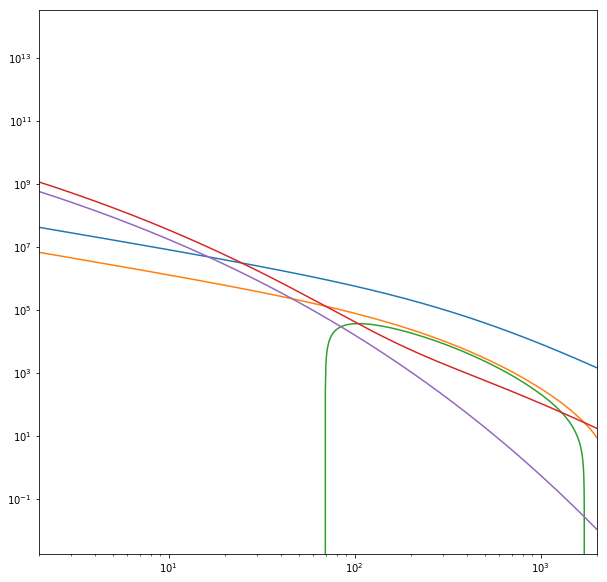

In [30]:
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_tot[999])
plt.loglog(radii, rho_b[999])
plt.loglog(radii, rho_gas[999])
plt.loglog(radii, rho_star[999])
plt.loglog(radii, rho_bcg[999])
plt.xlim(2.0, 2000.0)

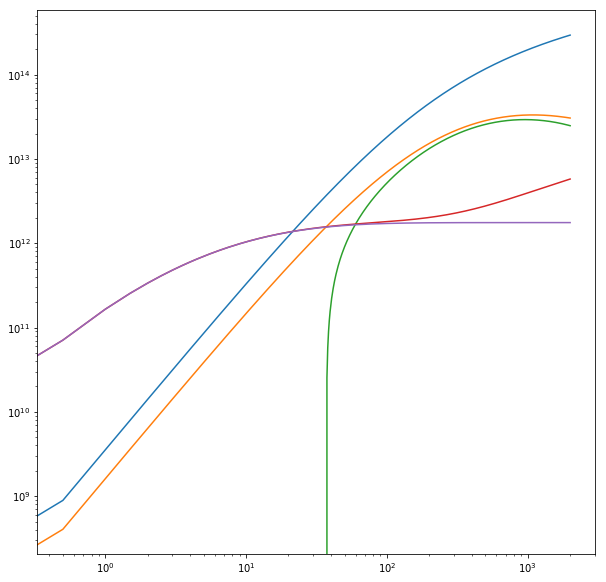

In [28]:
plt.figure(figsize=(10,10))
plt.loglog(radii, m_tot[100])
plt.loglog(radii, m_b[100])
plt.loglog(radii, m_gas[100])
plt.loglog(radii, m_star[100])
plt.loglog(radii, m_bcg[100])

In [29]:
mue = 1.0/0.88
n_e = (rho_gas*u.Msun/u.kpc**3).to_equivalent("cm**-3", "number_density", mu=mue)